In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.data import get_distribution
from labproject.utils import set_seed

set_seed(0)
plt.rcParams['figure.dpi'] = 150


In [2]:
toy_data = get_distribution("toy_2d")
datagen = toy_data()
data = datagen.sample(1000)

def update_toy_mog(datagen,means,covs,weights):
    datagen.means = means
    datagen.covs = covs
    datagen.weights = weights

    datagen.gaussians = [
        torch.distributions.MultivariateNormal(mean, covariance)
        for mean, covariance in zip(datagen.means, datagen.covariances)
    ]    
    return datagen

means2 = torch.Tensor([
            [0.0, 2.5],
            [-1.0, -0.5],
            [1.0, -2.0],
            [-2.0, -1.0],
        ])
            
covariances2 = torch.tensor(
                        [
                            [[1.0, 0.2], [0.2, 1.0]],
                            [[1.0, -0.7], [-0.7, 1.0]],
                            [[1.0, 0.0], [0.0, 1.0]],
                            [[0.5, 0.0], [0.0, 0.5]],
                        ]
                        )
weights2 = torch.tensor([0.3, 0.2, 0.1, 0.5])
datagen2 = update_toy_mog(datagen,means2,covariances2,weights2)
data2 = datagen2.sample(1000)

In [3]:
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

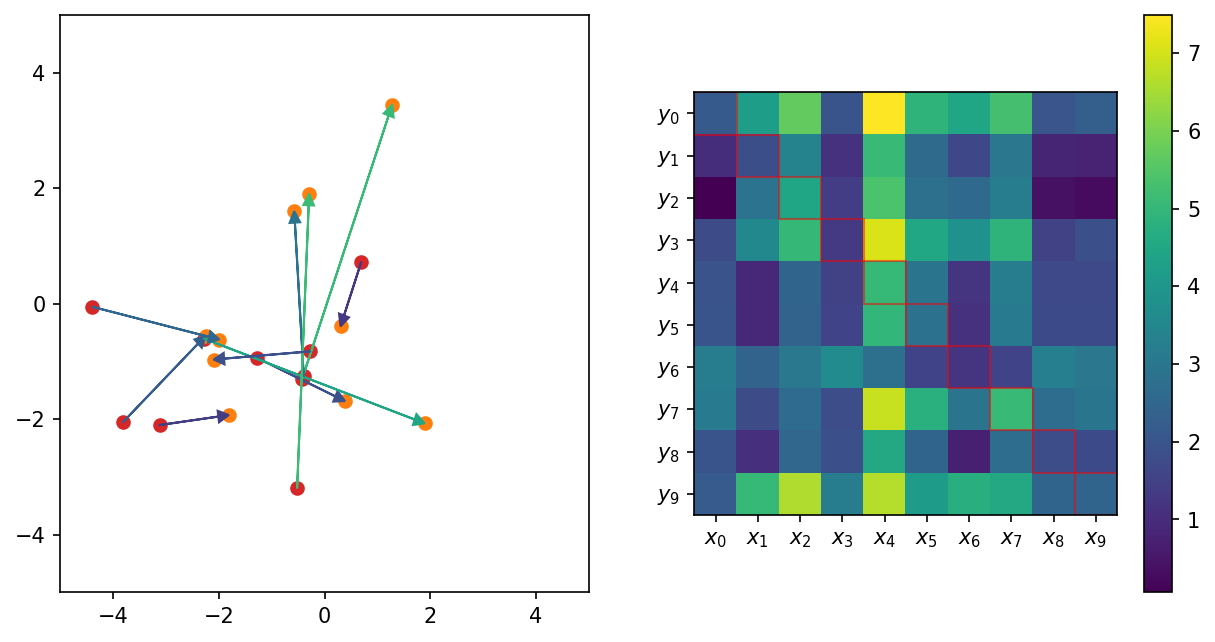

In [4]:
plot_data = data[:10]
plot_data2 = data2[:10]
pairdist = torch.cdist(plot_data,plot_data2)

fig,axs = plt.subplots(1,2,figsize=(10,5))
colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(10)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(10)])
for i in range(10):
    highlight_cell(i,i,ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2[:, 0], plot_data2[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
for ind,p1,p2 in zip(indices,plot_data,plot_data2):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,ind].item()/pairdist.max().item()))



In [5]:
cmap = cbar.cmap
print(cmap(pairdist[0,0]))

(0.993248, 0.906157, 0.143936, 1.0)


tensor([2, 9, 6, 8, 1, 7, 4, 3, 5, 0])


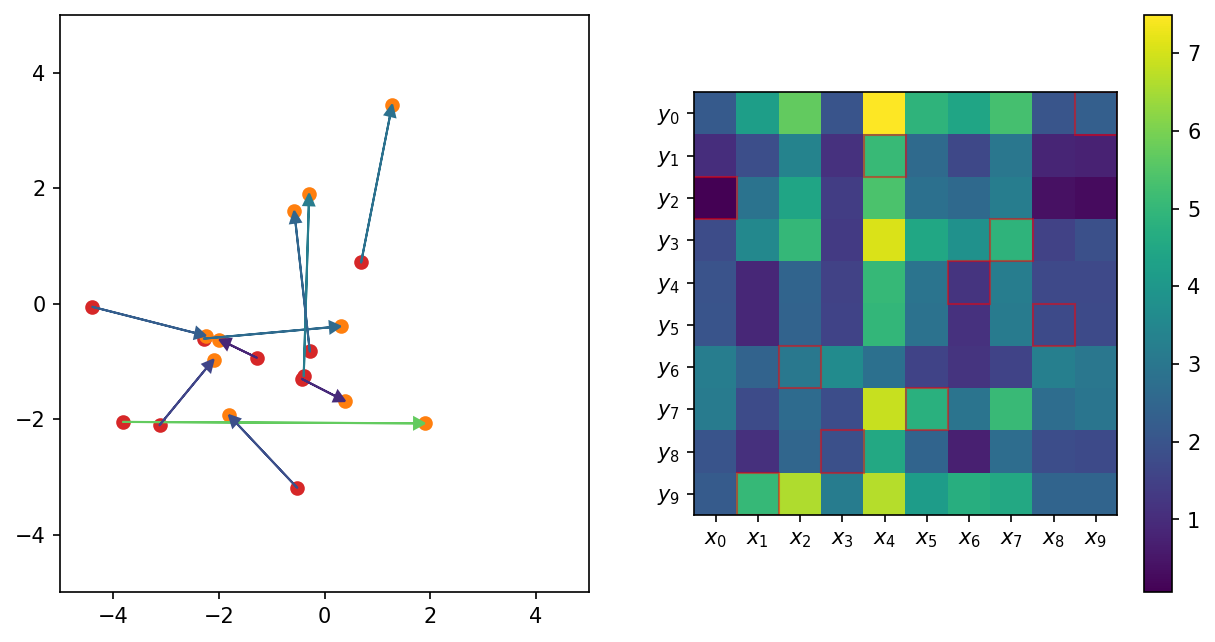

In [6]:
permutation = torch.randperm(plot_data2.size()[0])
print(permutation)
plot_data2_copy = plot_data2[permutation]
#pairdist = torch.cdist(plot_data,plot_data2)

fig,axs = plt.subplots(1,2,figsize=(10,5))

colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(10)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(10)])
for i in range(10):
    highlight_cell(i,permutation[i],ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2_copy[:, 0], plot_data2_copy[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))



tensor([8, 9, 0, 3, 1, 6, 4, 2, 7, 5])


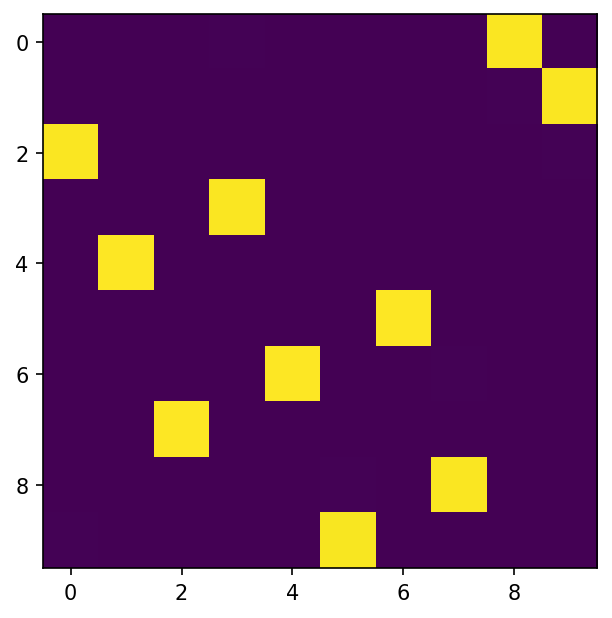

In [7]:
cost,transport = sinkhorn_algorithm(plot_data,plot_data2,epsilon=1e-3,niter=2000)
plt.imshow(transport)
print(transport.argmax(dim=1))

tensor([8, 9, 0, 3, 1, 6, 4, 2, 7, 5])


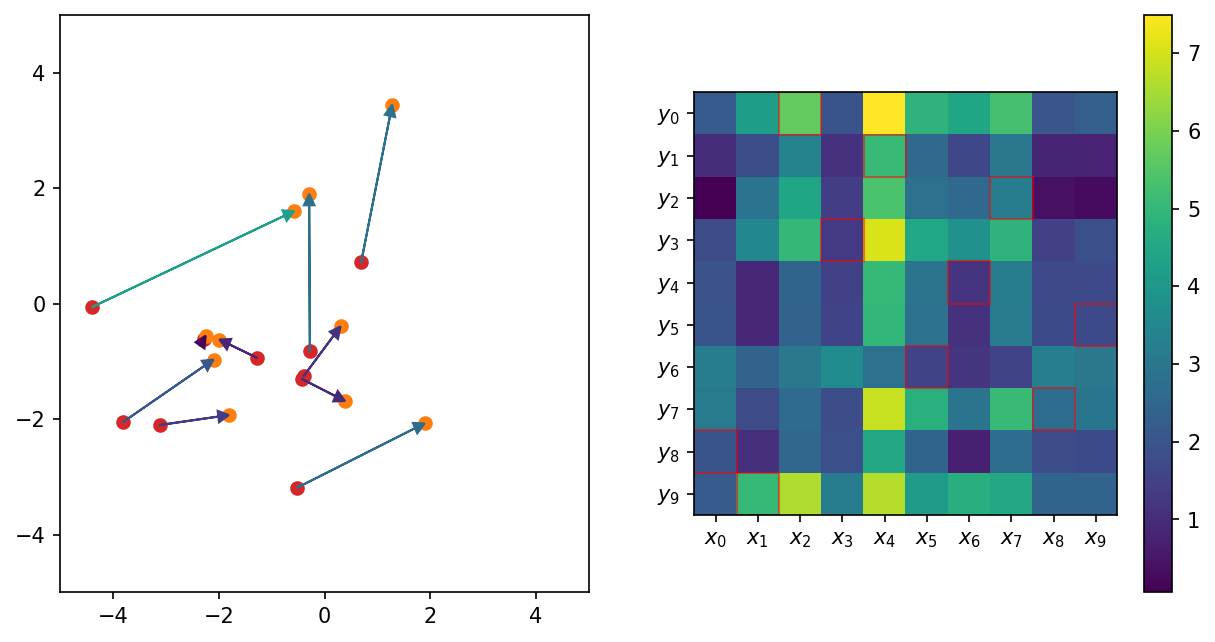

In [8]:
permutation = transport.argmax(dim=1)
print(permutation)
plot_data2_copy = plot_data2[permutation]
# pairdist = torch.cdist(plot_data,plot_data2_copy)

fig,axs = plt.subplots(1,2,figsize=(10,5))

colors = axs[1].imshow(pairdist)
axs[1].set_xticks(np.arange(len(pairdist[:,0])),labels=['$x_{}$'.format(i) for i in range(10)])
axs[1].set_yticks(np.arange(len(pairdist[:,0])),labels=['$y_{}$'.format(i) for i in range(10)])
for i in range(10):
    highlight_cell(i,permutation[i],ax=axs[1],color="r",alpha=0.5)
cbar = fig.colorbar(colors, ax=axs[1], location='right')




axs[0].scatter(plot_data[:, 0], plot_data[:, 1],color="C3")
axs[0].scatter(plot_data2_copy[:, 0], plot_data2_copy[:, 1],color="C1")
axs[0].set_xlim(-5,5)
axs[0].set_ylim(-5,5)
indices = torch.arange(0,len(plot_data))
for ind,p1,p2 in zip(indices,plot_data,plot_data2_copy):
    axs[0].arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],head_width=0.2, head_length=0.2,length_includes_head=True,color = cbar.cmap(pairdist[ind,permutation[ind]].item()/pairdist.max().item()))


